In [2]:
import os
import pandas as pd
from torchvision import transforms
from torchvision.datasets.folder import default_loader
from torch.utils.data import Dataset, DataLoader, random_split
import torch

# Config
IMG_DIR = '../generated'
CSV_PATH = './generated_labels.csv'
IMG_SIZE = (64, 64)
BATCH_SIZE = 16

class HeatmapDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None):
        self.data = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.transform = transform
        self.classes = sorted(self.data['category'].unique())
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.img_dir, row['filename'])
        image = default_loader(img_path).convert('L')  # grayscale
        label = self.class_to_idx[row['category']]
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = HeatmapDataset(CSV_PATH, IMG_DIR, transform)
train_len = int(0.8 * len(dataset))
test_len = len(dataset) - train_len
train_set, test_set = random_split(dataset, [train_len, test_len])

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE)


CNN Model

In [4]:
import torch.nn as nn

class CNNClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 16 * 16, 128), nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

model = CNNClassifier(num_classes=len(dataset.classes))


Training 

In [5]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(10):
    model.train()
    running_loss = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        output = model(imgs)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}: Loss = {running_loss:.4f}")


Epoch 1: Loss = 21.5816
Epoch 2: Loss = 19.2070
Epoch 3: Loss = 16.8887
Epoch 4: Loss = 14.6422
Epoch 5: Loss = 12.7016
Epoch 6: Loss = 9.7643
Epoch 7: Loss = 7.4482
Epoch 8: Loss = 5.6504
Epoch 9: Loss = 5.4166
Epoch 10: Loss = 4.8776


Evaluation 


✅ Test Accuracy: 45.45%

📊 Classification Report:

                         precision    recall  f1-score   support

       Error Correction      1.000     1.000     1.000         2
        Hidden Subgroup      0.750     0.333     0.462         9
        Linear Equation      0.667     1.000     0.800         2
      Logical Operation      0.000     0.000     0.000         5
       Machine Learning      0.000     0.000     0.000         2
     Quantum Arithmetic      0.200     0.333     0.250         3
  Quantum Communication      1.000     1.000     1.000         1
     Quantum Simulation      0.500     1.000     0.667         4
           Quantum Walk      0.400     1.000     0.571         2
Search and Optimization      0.000     0.000     0.000         3

               accuracy                          0.455        33
              macro avg      0.452     0.567     0.475        33
           weighted avg      0.439     0.455     0.403        33



/home/kidus-tessma/miniconda3/envs/cs395/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kidus-tessma/miniconda3/envs/cs395/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kidus-tessma/miniconda3/envs/cs395/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

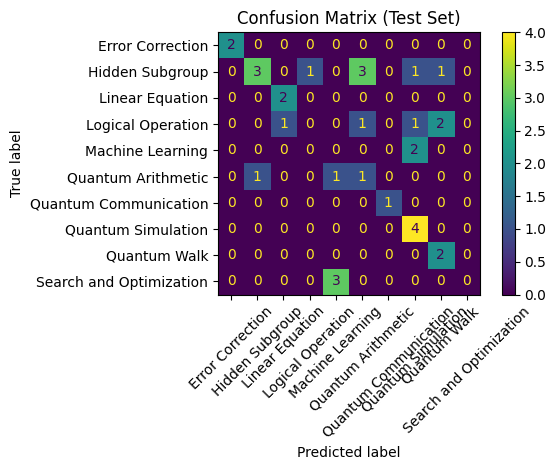

In [10]:
from sklearn.metrics import (
    accuracy_score, confusion_matrix, ConfusionMatrixDisplay,
    precision_score, recall_score, f1_score, classification_report
)
import matplotlib.pyplot as plt
import numpy as np

# Set model to evaluation mode
model.eval()
all_preds, all_labels = [], []

# Get predictions on test set
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1).cpu()
        all_preds.extend(preds)
        all_labels.extend(labels)

# Accuracy
acc = accuracy_score(all_labels, all_preds)
print(f"\n✅ Test Accuracy: {acc:.2%}\n")

# Unique labels in test set (used for mapping to class names)
unique_labels = np.unique(all_labels)
display_labels = [dataset.classes[i] for i in unique_labels]

# Classification Report (Precision, Recall, F1)
print("📊 Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=display_labels, digits=3))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds, labels=unique_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()



